In [10]:
import torch
from torch import nn

from uqvae.models.base import Encoder, Decoder
from uqvae.dataset import load
from uqvae import utils
from uqvae.metrics import mutual_information

import os
import yaml

from types import SimpleNamespace

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams["text.usetex"] = True
plt.rcParams["savefig.pad_inches"] = 0.0
plt.rcParams["savefig.transparent"] = True

In [11]:
vnum = 0
f = os.path.normpath(f"../lightning_logs/version_{vnum}")
with open(os.path.join(f, "hparams.yaml")) as stream:
    hparams = SimpleNamespace(**yaml.safe_load(stream))

device = torch.device("cuda" if hparams.cuda else "cpu")
best_state_dict = torch.load(
    os.path.join(f, "checkpoints/best.ckpt"), map_location=device
)

if hparams.transform_data:
    data_transformer = torch.load(os.path.join(f, "checkpoints/data_transformer.ckpt"))

In [12]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x).rsample()
        pxz = self.decoder(z)
        return pxz.loc(), pxz.scale()


with utils.reproduce(seed=42):
    encoder = Encoder(hparams.data_dim, hparams.compress_dims, hparams.embedding_dim)
    decoder = Decoder(hparams.embedding_dim, hparams.decompress_dims, hparams.data_dim)
    vae = VAE(encoder, decoder).to(device)
    vae.load_state_dict(best_state_dict["state_dict"])

In [13]:
data, _, _, _ = load("../data/fulldataset.csv")
tdata = data.astype("float32")
if hparams.transform_data:
    tdata = data_transformer.transform(tdata)
else:
    tdata = tdata.values

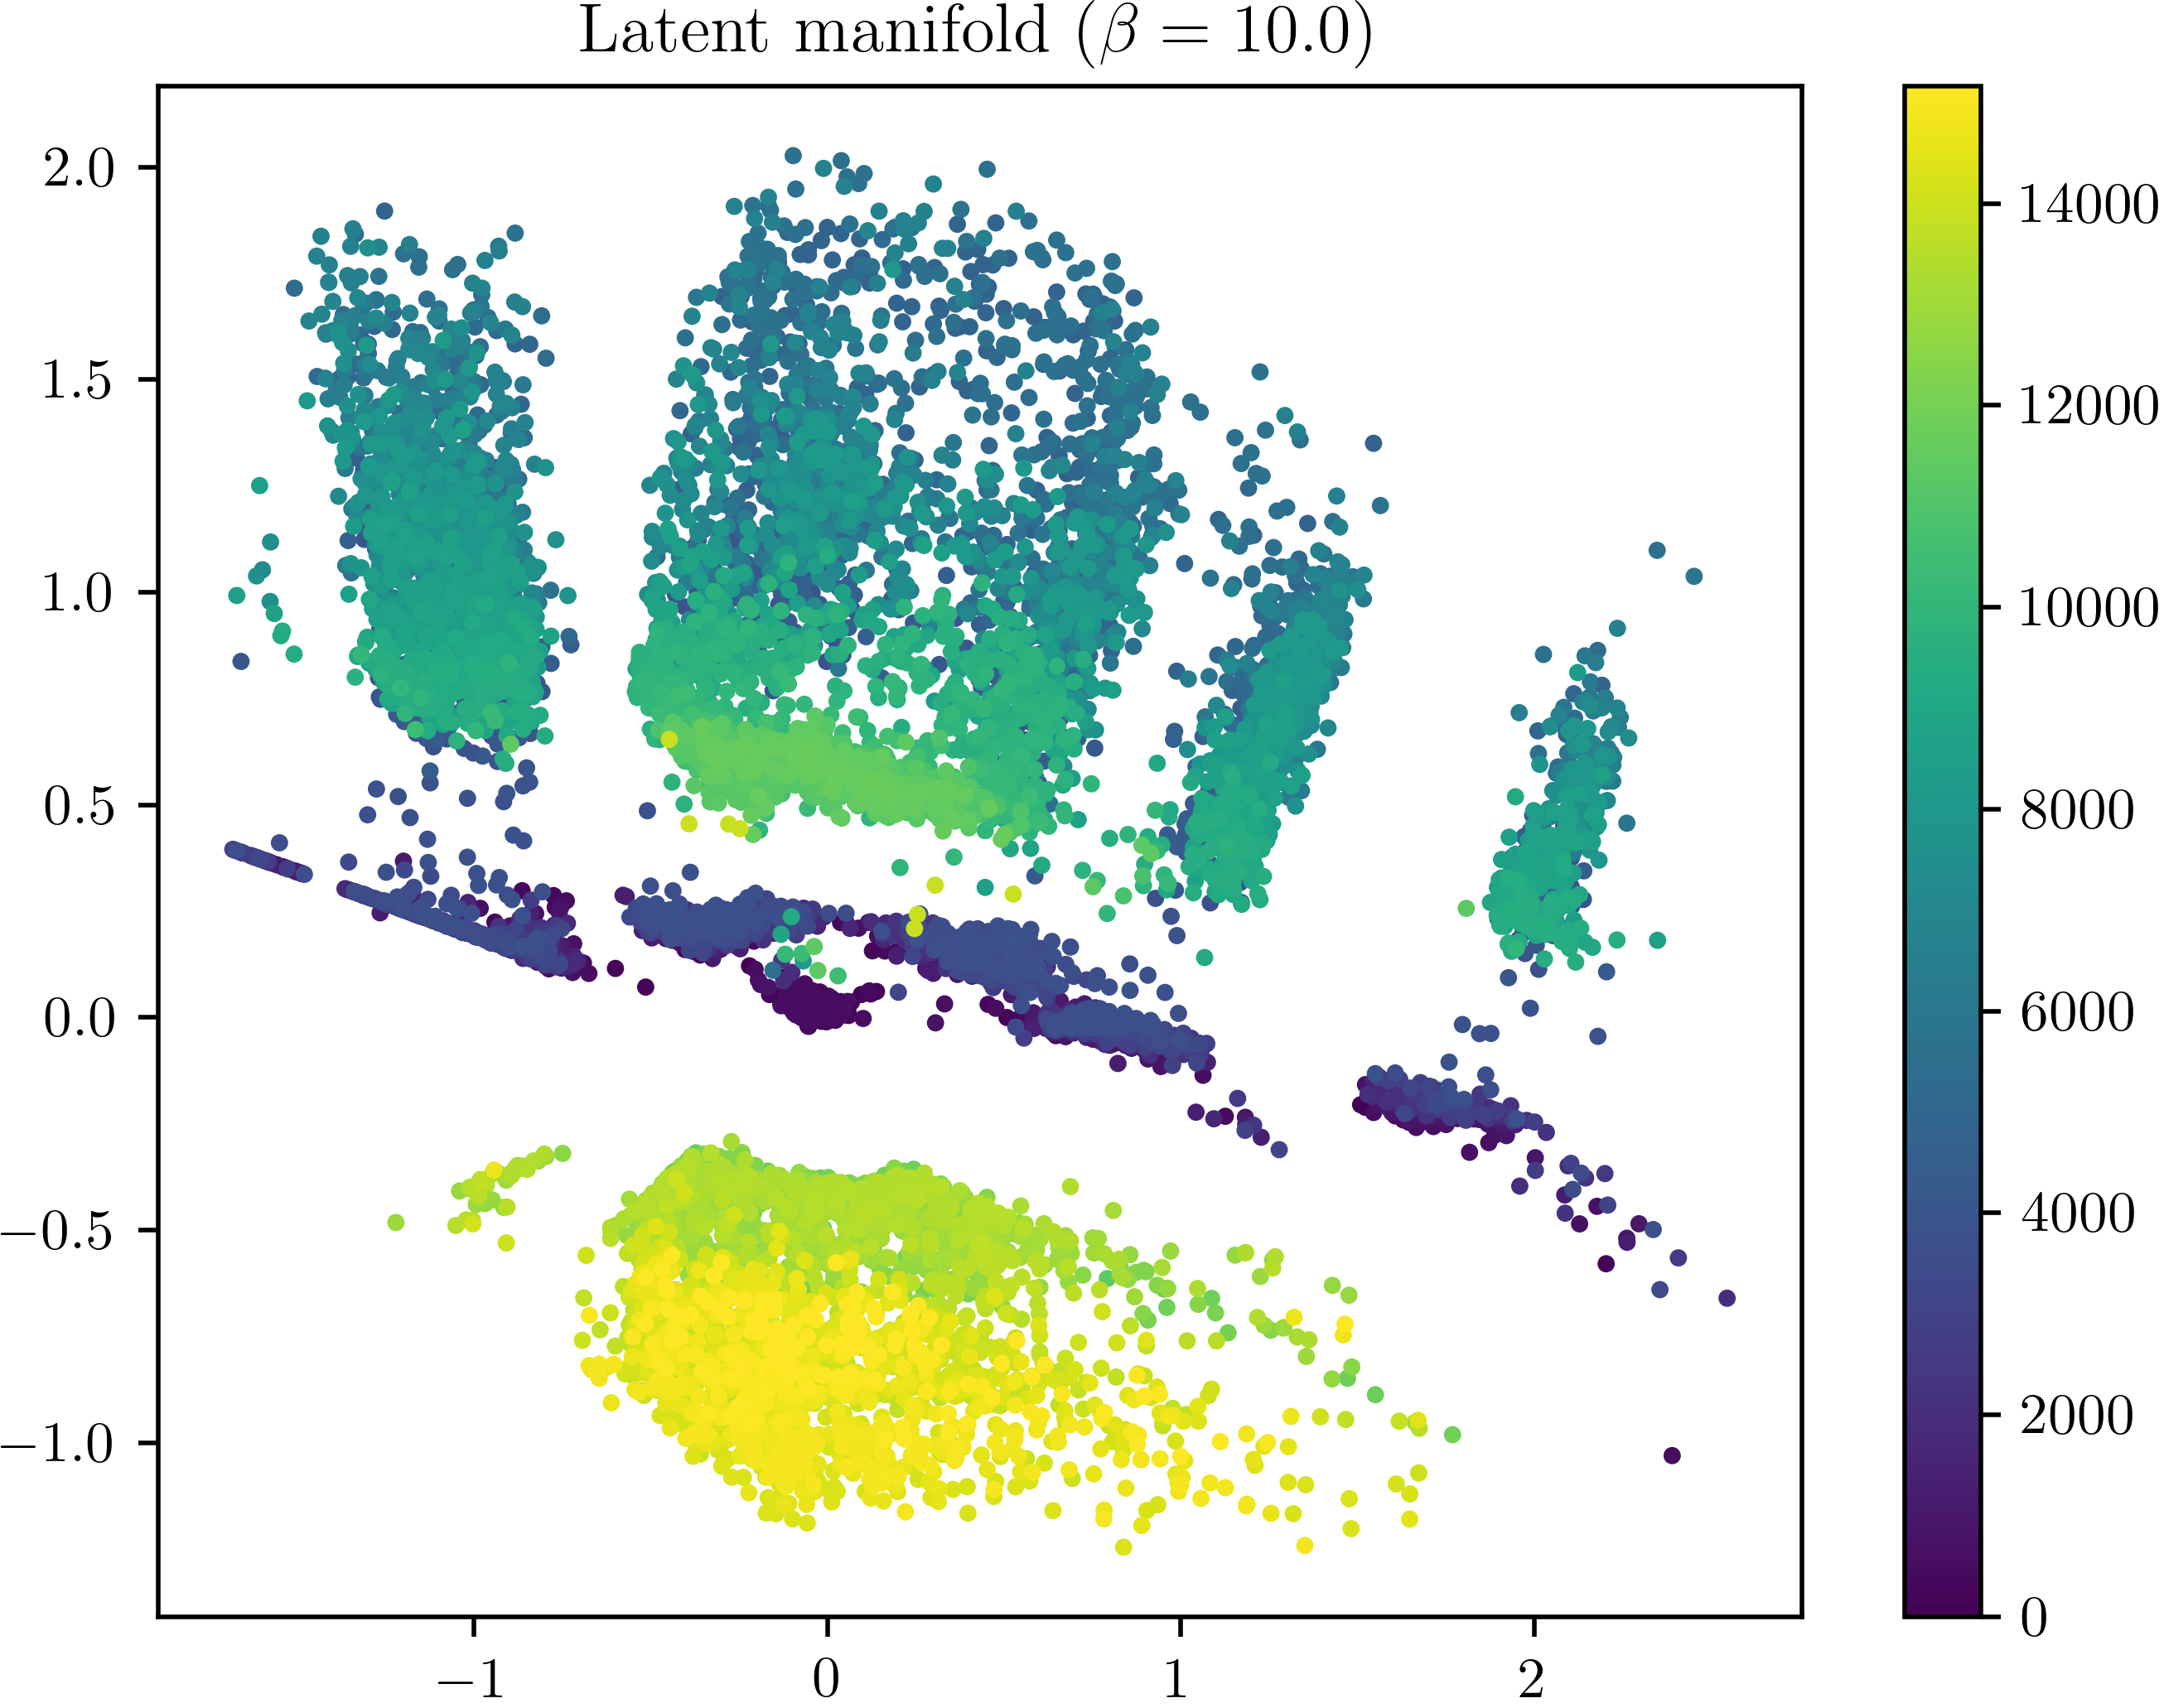

In [14]:
with torch.no_grad():
    x = torch.as_tensor(tdata, device=device, dtype=torch.float32)
    z = vae.encoder(x).rsample().cpu()

plt.figure(dpi=500)
plt.title(r"Latent manifold ($\displaystyle\beta=10.0$)")
plt.scatter(
    *np.split(z, 2, 1),
    c=data.index.tolist(),
    vmin=min(data.index.tolist()),
    vmax=max(data.index.tolist()),
    s=4,
)
plt.colorbar()

In [15]:
x = torch.linspace(-2.0, 2.0, 200)
y = torch.linspace(-2.0, 2.0, 200)
x, y = torch.meshgrid(x, y, indexing="xy")
ZZ = torch.vstack((x.flatten(), y.flatten())).t()
f_vals = (
    mutual_information(
        vae.decoder,
        ZZ.to(device),
        n_simulations=100,
        n_sampled_outcomes=10,
    )
    .detach()
    .cpu()
)

mutual_information: 100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


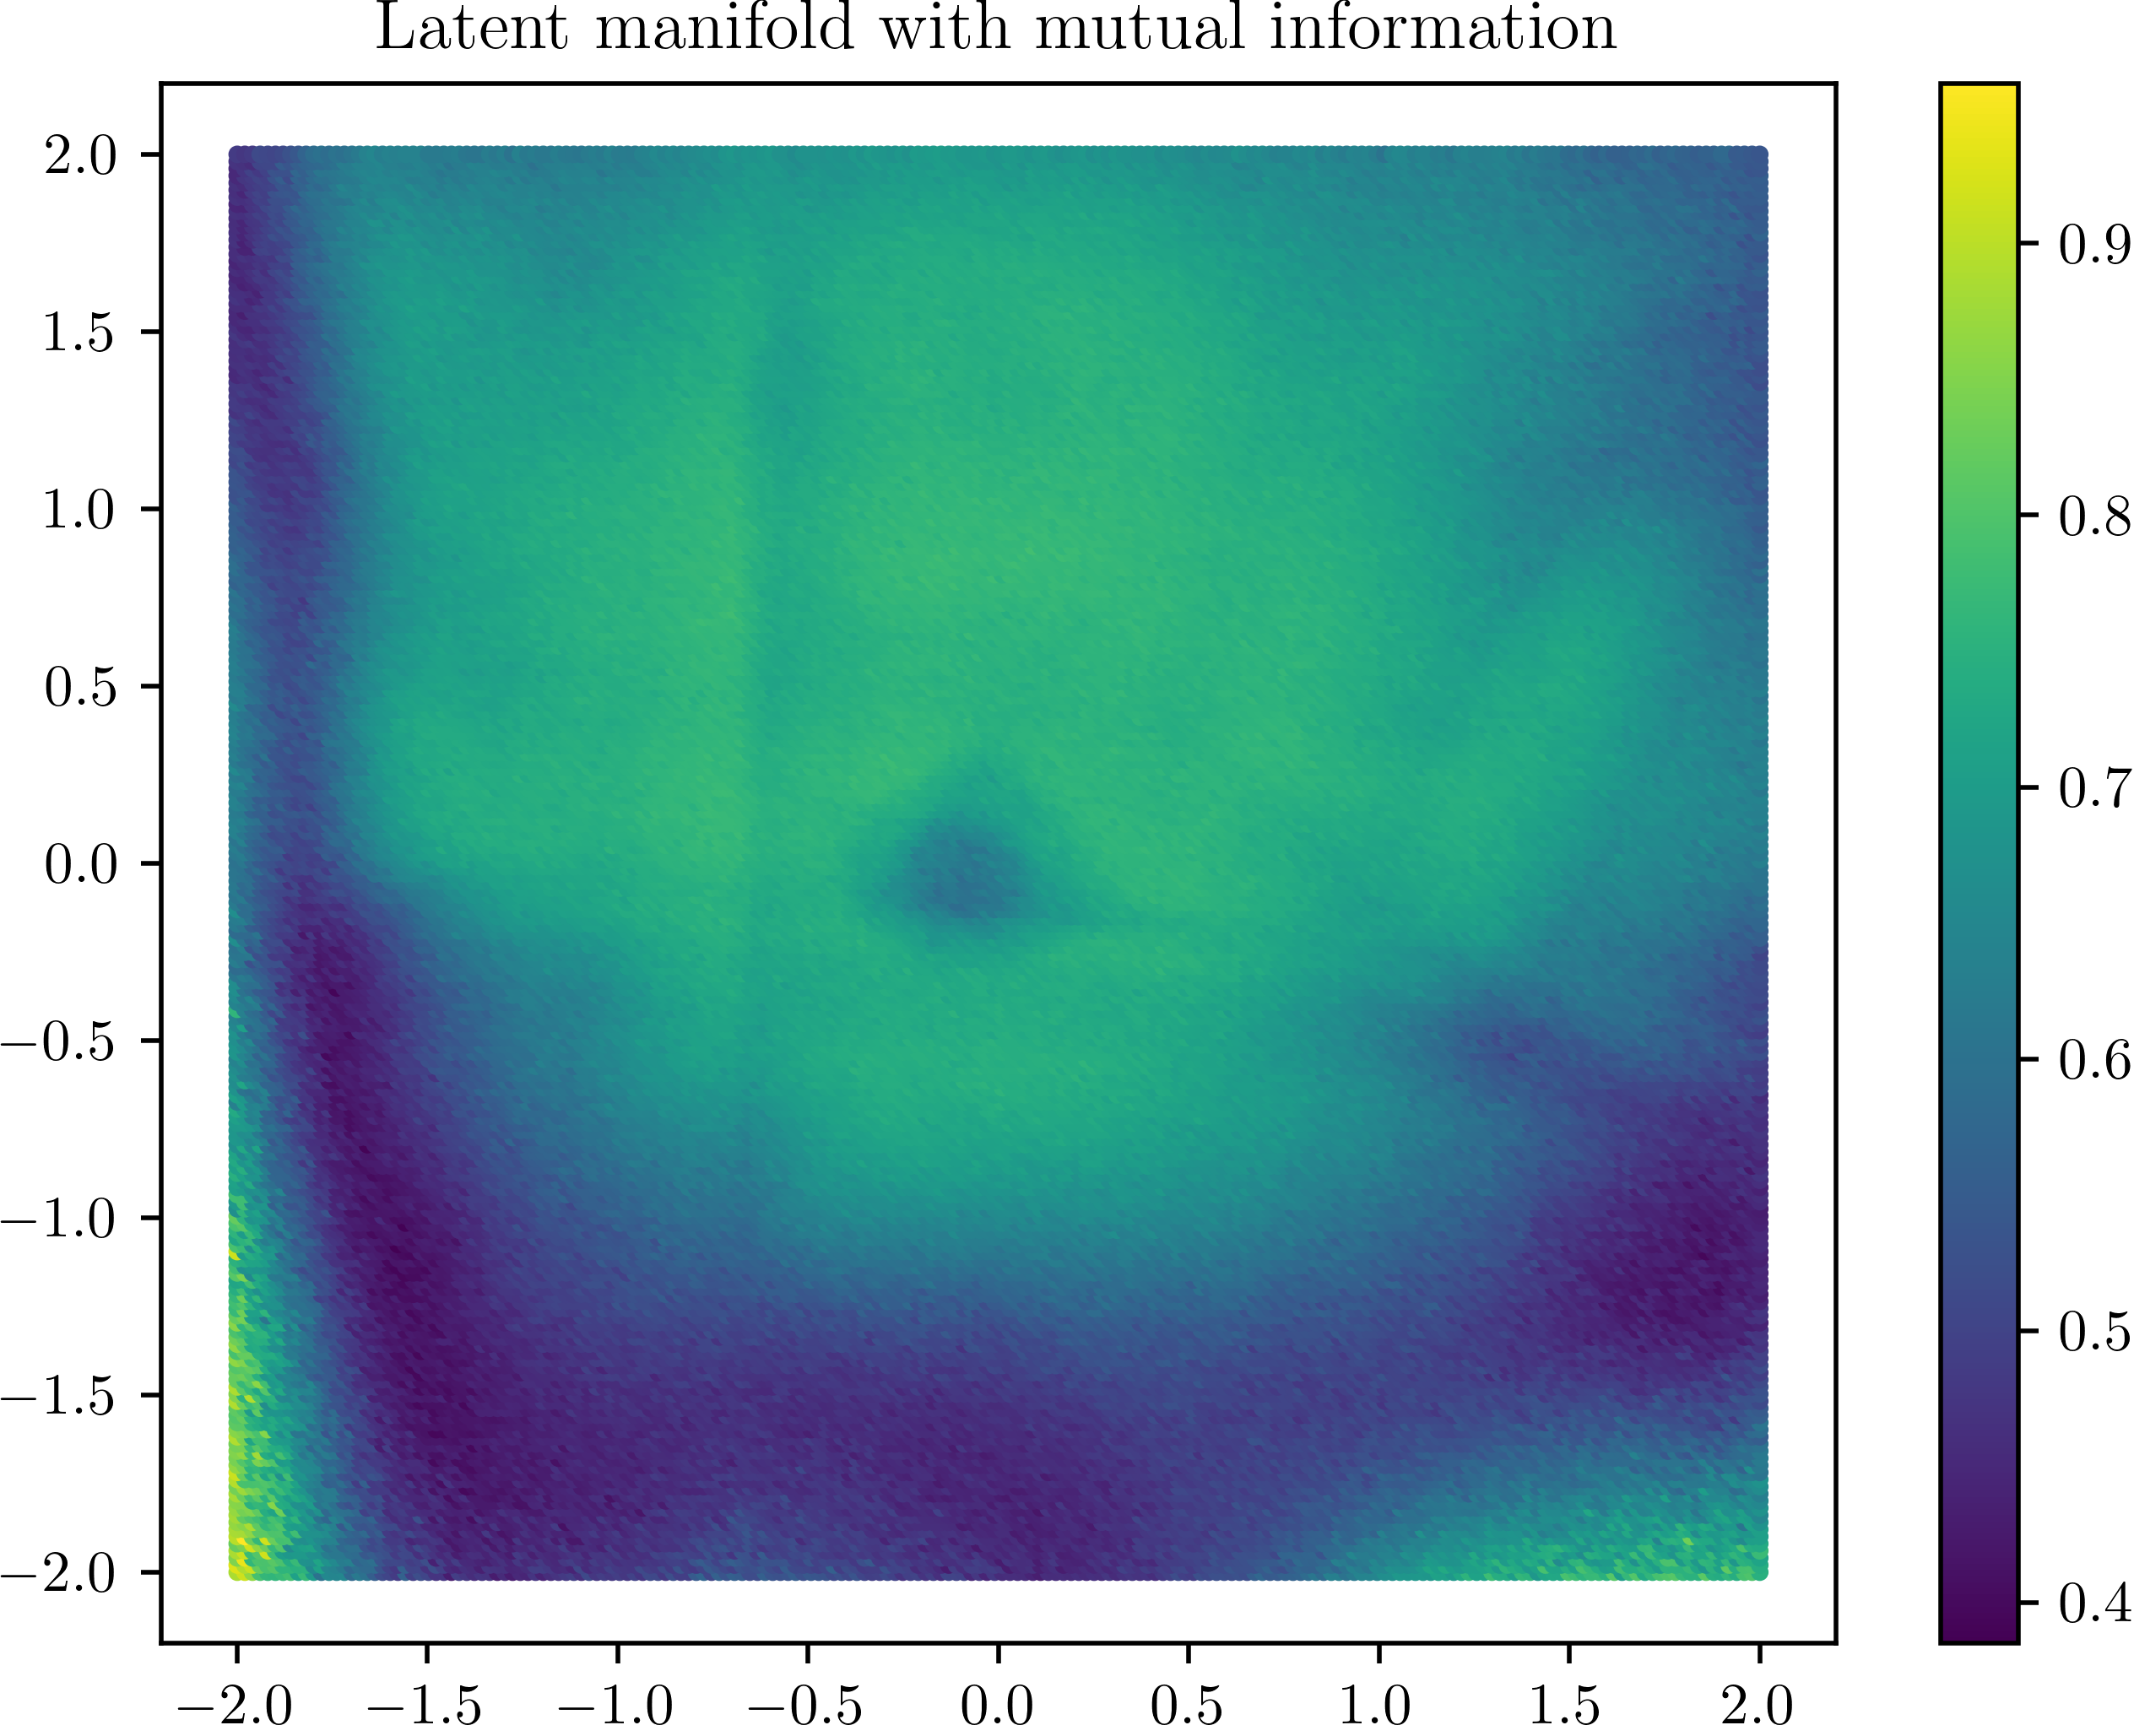

In [16]:
mask = torch.where(f_vals > 10.0, 0.0, f_vals)


plt.figure(dpi=500)
plt.title(r"Latent manifold with mutual information")
plt.scatter(
    *np.split(ZZ, 2, 1),
    c=mask,
    vmin=min(mask),
    vmax=max(mask),
    s=4,
)

plt.colorbar()